# DSME Bonus Point Assignment II Part A
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2021-01-29</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [5]:
# General imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


# Create solution folder
Path("solution/").mkdir(exist_ok=True)

## Question A1 - Q-Tables
### a) The FrozenLake environment

In [6]:
import gym

# ********************
# TODO Create environment
env = gym.make('FrozenLake-v0')


# TODO Render initial state
env.render()

# ********************


SFFF
FHFH
FFFH
HFFG


### b) Manual Navigation

In [4]:
from gym.envs.toy_text.frozen_lake import LEFT, DOWN, RIGHT, UP  # Import action constants

# Reset frozenlake env to reproducible state
env.seed(42)
env.reset()
env.render('human')

# ********************
# TODO Find action sequence that leads to the goal
env.step(DOWN)
env.step(LEFT)
env.step(RIGHT)
env.step(DOWN)
env.step(DOWN)
env.step(RIGHT)
env.step(RIGHT)


# ********************


SFFF
FHFH
FFFH
HFFG


(15, 1.0, True, {'prob': 0.3333333333333333})

In [5]:
# Test Code
np.testing.assert_equal(env.s, 15, err_msg="Env not in goal state")
"ok"

'ok'

### c) Building the Q-Table

Training: 100%|██████████| 2000/2000 [00:00<00:00, 2832.13it/s]


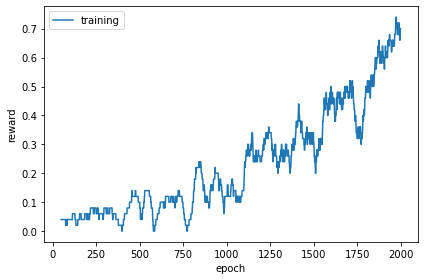

In [10]:
# ********************
# TODO Initialize Q-table of size 16x4

Q = np.random.randn(16, 4) / 100
Q[15, :] = 1
Q[5, :] = 0
Q[7, :] = 0
Q[11, :] = 0
Q[12, :] = 0


# ********************

# Hyperparameters
lr = 0.3
gamma = 0.99
num_episodes = 2000
max_steps_per_episode = 100

# Create lists to contain total rewards and steps per episode
rewards = np.zeros(num_episodes)

for i in tqdm(range(num_episodes), desc="Training"):
    # Reset environment and observe initial state
    s = env.reset()

    # The Q-Table learning algorithm
    for _ in range(max_steps_per_episode):
        # ********************
        # TODO Choose action
        epsilon =  .5 * (1 - i / 2000)

        if np.random.random() < epsilon:
            a = np.random.randint(4)
        else:
            a = np.argmax(Q[s])

        lr = .5 * (1 - i / 2000)


        # ********************

        # Get new state and reward from environment
        s_new, r, done, _ = env.step(a)

        # ********************
        # TODO Update Q-table
        Q[s, a] = Q[s, a] + lr * (r + gamma * Q[s_new].max() - Q[s, a])


        # ********************

        # Bookkeeping
        rewards[i] += r
        s = s_new

        if done:  # Check if episode terminated
            break

# Plot rewards
sns.lineplot(data=pd.DataFrame(rewards, columns=["training"]).rolling(50).mean())
plt.xlabel("epoch")
plt.ylabel("reward")
plt.tight_layout()
plt.savefig("solution/a1c-train.png")

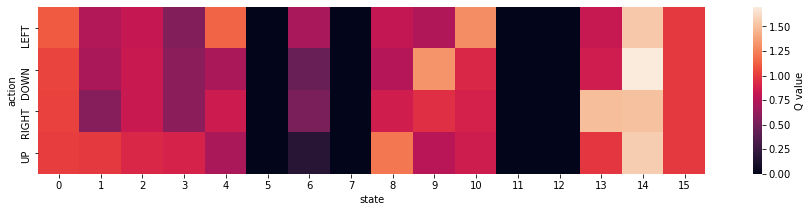

In [7]:
# Plot Q-table
plt.figure(figsize=(14, 3))
sns.heatmap(Q.T, square=True, cbar_kws={'label': 'Q value'},yticklabels=["LEFT", "DOWN", "RIGHT", "UP"])
plt.xlabel("state")
plt.ylabel("action")
plt.tight_layout()
plt.savefig("solution/a1c-q-values.png")

In [8]:
# Test Code

def rollout(env, Q, seed=None):
    """Perform single rollout"""
    reward = 0
    env.seed(seed)
    s = env.reset()
    for _ in range(max_steps_per_episode):
        # Choose action greedily from Q-table
        a = np.argmax(Q[s, :])
        s, r, done, _ = env.step(a)
        reward += r
        if done:  # Check if episode terminated
            break
    return reward

validation_reward = np.mean([rollout(env, Q, i) for i in range(100)])
print(f"Validation reward: {validation_reward}", )
assert validation_reward > 0.5, f"Average reward of learned Q-table should be greater than 0.5"
"ok"

Validation reward: 0.73


'ok'

## Question A2 - Policy Gradients

In [1]:
# Imports
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
 

Note: The next cell is optional, as this will _not_ run on the JupterHub. To render the CartPole environemnt, you need to set up your Jupyter environment locally (see assignment PDF). Rendering is not required for this assignment, but the visualization may help you to understand what your policy is atually learning.

In [2]:
# Take a look at the environment
env = gym.make('CartPole-v1')

for _ in range(10):
    state, done = env.reset(), False
    while not done: 
        action = env.action_space.sample() # Random action
        state, _, done, _ = env.step(action)

        env.render()

env.close()

### a) Defining the Policy

In [7]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # TODO Create layers
        self.model = nn.Sequential(nn.Linear(4, 32), nn.ReLU(), nn.Dropout(.2), 
            nn.Linear(32, 32), nn.ReLU(), #nn.Dropout(.2), 
            nn.Linear(32, 2), nn.Softmax())



    def forward(self, x):
        # TODO Implement forward pass
        return self.model(x)

In [8]:
# Test code
_test_output = Policy()(torch.tensor([[1.0,2,3,4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
np.testing.assert_almost_equal(_test_output.detach().numpy().sum(), 1, err_msg="Output is not a probability distribution.")
"ok"

'ok'

### b) Action Sampling

In [9]:
def sample_action(probs):
    """Sample one action from the action distribution of this state.
    
    Args:
        probs: action probabilities

    Returns:
        action: The sampled action
        log_prob: Logarithm of the probability for sampling that action
    """
    probs = probs.float() / probs.sum()
    dist = torch.distributions.Categorical(probs)
    sample = dist.sample()
    return sample, dist.log_prob(sample)

In [14]:
# Test code
_test_action, _test_log_prob = sample_action(torch.tensor([1,2,3,4]))
assert _test_action in [0, 1, 2, 3], f"Invalid action {_test_action}"
np.testing.assert_approx_equal(_test_log_prob, np.log((_test_action+1)/10))
"ok"

'ok'

### c)

In [15]:
def estimate_return(rewards, gamma=0.99):
    """Estimate return based of observed rewards
    
    Args:
        rewards: Series of observed rewards
        gamma: discount factor
        """
    
    returns = torch.zeros(rewards.shape[0], dtype=torch.float64)
    returns[-1] = rewards[-1]
    for i in range(1, len(rewards)):
        returns[-i - 1] = rewards[-i - 1] + gamma * returns[-i]
    returns -= returns.mean(-1)
    if returns.std() != 0:
        returns /= returns.std(-1, unbiased=False)
    return returns

In [16]:
# Test code
np.testing.assert_array_almost_equal(
     estimate_return(np.ones(10), gamma=0.99), 
    [1.54572815, 1.21139962, 0.87369404, 0.53257729, 0.18801491,-0.16002789, -0.51158628, -0.86669576, -1.22539221, -1.58771185])
"ok"

'ok'

### d) Training Loop

Mean training reward 500.00: 100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]


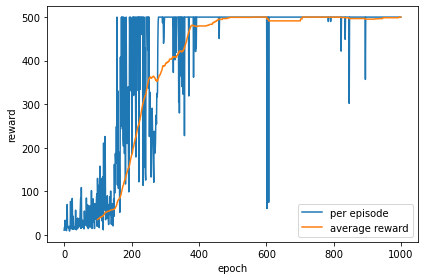

In [26]:
env = gym.make('CartPole-v1')
policy = Policy()

# Hyperparams
episodes = 1000
gamma = 0.99
learn_rate = 3e-3
optimizer = torch.optim.Adam(policy.parameters(), lr=learn_rate)

total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        # Run one episode
        log_probs = []
        rewards = []
        state, done = env.reset(), False
        while not done:
            # Take a step
            # ********************
            # TODO Sample action for current state
            
            
            action, log_prob = sample_action(policy(torch.tensor(state, dtype=torch.float32)))
            action = action.detach().numpy()

            # ********************
            state, reward, done, _ = env.step(action)

            # Bookkeeping
            log_probs.append(log_prob)
            rewards.append(reward)

        total_rewards.append(sum(rewards))


        # ********************
        # TODO Compute loss
        
        policy_loss = 0
        for prob, r in zip(log_probs, estimate_return(np.array(rewards))):
            policy_loss -= prob * r


        # ********************

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")


# Save model
with open("solution/a2d.pt", "wb") as f:
    torch.save(policy, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/a2d.png")

In [27]:
# Test code
policy.eval() # Switch to evaluation mode

def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps
        
_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


'ok (Average reward 500.00)'

In [28]:
# Take a look at the learned policy (this will not run on the JupyterHub)
greedy = True

policy.eval() # Switch to evaluation mode
state, done = env.reset(), False
while not done: 
    probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
    if greedy:
        action = np.argmax(probs.detach().numpy())  # Chose optimal action
    else:
        action = sample_action(probs)[0]  # Sample from action distribution
    state, _, done, _ = env.step(action)
    env.render()

env.close()